### Time Series Classification from EEG data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import fftconvolve, welch
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier

from aeon_neuro.transformations import BandPowerSeriesTransformer

This example starts by simulating EEG-like series' with power law noise. This setting demonstrates a supervised multiclass classification task, akin to [sleep stage classification](https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html), where power within specific frequency bands changes over the brain throughout different sleep stages.

We begin by constructing a basic scikit-learn pipeline. This pipeline first applies a band power transformer, which estimates the power of an EEG signal across five physiological sub-bands using windowed FFTs, and then classifies the results using a decision tree.

In [2]:
# settings
n_timepoints, sfreq, window_size = 1000, 256, 50

# sequency of transformers with a final classifier
pipeline = make_pipeline(
    BandPowerSeriesTransformer(sfreq, n_per_seg=window_size),
    FunctionTransformer(lambda X: X.T),  # (n_timepoints//window_size, 5_bands)
    DecisionTreeClassifier(),
)

Next, we simulate univariate training and testing series, where each series transitions (every 1000 timepoints) from red to pink to white to blue to violet noise. Specifically, the power $P(f)$ at frequency $f$ follows the relationship $P(f) \propto \frac{1}{f^\beta}$, with the spectral exponent $\beta$ changing every 1000 timepoints.

The labels indicate the different types of noise *after* the 'BandPowerSeriesTransformer' is applied, which estimates the power within five frequency bands using non-overlapping windows of 50 timepoints each.

In [3]:
def sim_powerlaw(sfreq, exponent, n_timepoints=1000, random_seed=0):
    """Simulate Gaussian noise with power law spectrum.
    (https://gist.github.com/nmayorov/e01d7081471d8ef95c4c42c4b8144224)
    """
    rng = np.random.default_rng(seed=random_seed)
    fir_coeffs = np.empty(n_timepoints)
    fir_coeffs[0] = 1
    for idx in range(1, len(fir_coeffs)):
        fir_coeffs[idx] = (0.5 * exponent + idx - 1) / idx * fir_coeffs[idx - 1]

    white_noise = rng.standard_normal(n_timepoints)
    scale = sfreq ** (1 - exponent)

    noise = fftconvolve(fir_coeffs, white_noise, axes=0)[:n_timepoints]

    return (scale * sfreq ** (1 - exponent)) ** 0.5 * noise


# define noise types
noise_colors = ["red", "pink", "white", "blue", "violet"]
noise_exponents = [2, 1, 0, -1, -2]

# generate X, y
X_train, X_test = [], []
for exponent in noise_exponents:
    x_train = sim_powerlaw(sfreq, exponent, n_timepoints=n_timepoints, random_seed=0)
    x_test = sim_powerlaw(sfreq, exponent, n_timepoints=n_timepoints, random_seed=5)
    X_train.append(x_train)
    X_test.append(x_train)

X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)
y_train = np.repeat(noise_colors, (n_timepoints / window_size))
y_test = y_train

print(f"X shape: {X_train.shape}\ny shape: {y_train.shape}")

X shape: (5000,)
y shape: (100,)


It is apparent from plotting the different noise types side-by-side in the time and frequency domains that they are visually difficult to separate in the time domain, but near perfectly separable in the frequency domain - especially in δ, θ, α, β, and γ EEG sub-bands (dashed vertical lines).

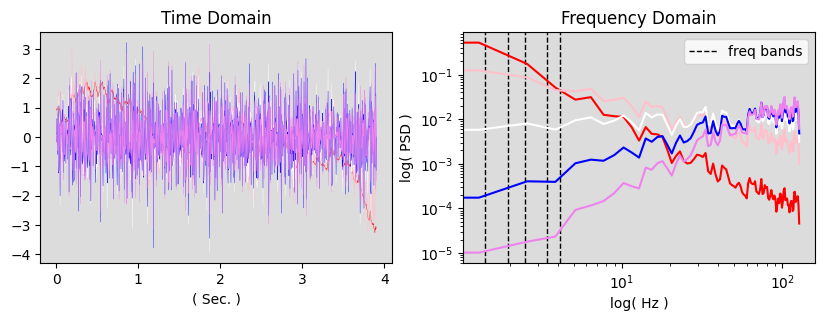

In [4]:
def plot_time_domain(x, sfreq, ax):
    """Plot series."""
    x = (x - x.mean()) / x.std()
    return ax.plot(np.arange(len(x)) / sfreq, x)[0]


def plot_frequency_domain(x, sfreq, ax):
    """Plot power spectral density."""
    freqs, powers = welch(x, sfreq, nperseg=200)
    powers /= np.sum(powers)
    return ax.loglog(freqs, powers)[0]


# δ, θ, α, β, and γ frequency bands
freq_bands = BandPowerSeriesTransformer.FREQ_BANDS
vlines = np.log([value[1] for value in freq_bands.values()])

# setup plots
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
[ax.set_facecolor("gainsboro") for ax in axs]
axs[0].set_title("Time Domain")
axs[0].set_xlabel("( Sec. )")
axs[1].set_title("Frequency Domain")
axs[1].set_xlabel("log( Hz )")
axs[1].set_ylabel("log( PSD )")
[axs[1].axvline(x=vline, color="k", ls="--", lw=1) for vline in vlines]
axs[1].legend(["freq bands"])

# add X_train, every 1000 timepoints (3.9 seconds)
for idx in range(len(noise_colors)):
    x = X_train[idx * n_timepoints : (idx + 1) * n_timepoints]
    plot_time_domain(x, sfreq, axs[0]).set(color=noise_colors[idx], lw=0.3)
    plot_frequency_domain(x, sfreq, axs[1]).set(color=noise_colors[idx])

We can further confirm the separability of these powerband features by fitting a decision tree classifier, which successfully separates the five noise types.

In [5]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Classification Accuracy : ", np.mean(y_pred == y_test))

Effective window size : 0.250 (s)
Effective window size : 0.250 (s)
Classification Accuracy :  1.0


While this is a simplified example with artificially distinct frequency bands, real EEG data presents a more complex scenario. Powerband features might be effective for classifying broad brain states, such as sleep stages, but could be less effective for other experimental tasks.

For instance, in the KDD dataset where the task is to classify whether a subject's hand is resting on a table ("rest") or raised ("task"), the powerband approach to feature selection yields only chance-level accuracy. In contrast, the [data loading example](data_loading.ipynb) shows that on the same dataset a time-domain method using convolution to extract features achieves a classification accuracy of 90%.

In [6]:
from aeon.datasets import load_classification

X_train, y_train = load_classification(
    name="KDD_MTSC", split="TRAIN", extract_path="../aeon_neuro/data/KDD_Examples"
)

X_test, y_test = load_classification(
    name="KDD_MTSC", split="TEST", extract_path="../aeon_neuro/data/KDD_Examples"
)

# reshape from collection to series, where y labels index time
n_cases, n_channels, n_timepoints = X_train.shape
assert X_train.shape == X_test.shape, "X_train.shape != X_test.shape"

X_train = X_train.reshape(n_channels, n_timepoints * n_cases)
y_train = y_train.repeat(n_timepoints / window_size)
X_test = X_test.reshape(n_channels, n_timepoints * n_cases)
y_test = y_test.repeat(n_timepoints / window_size)

print(f"X shape: {X_train.shape}\ny shape: {y_train.shape}")

X shape: (4, 4000)
y shape: (80,)


In [7]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Classification Accuracy : ", np.mean(y_pred == y_test))

Effective window size : 0.250 (s)
Effective window size : 0.250 (s)
Classification Accuracy :  0.475
